In [1]:
#importing libraries
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler

In [2]:
beer = pd.read_csv('data/recipeData.csv', index_col='BeerID', encoding='latin1')

In [3]:
beer.shape

(73861, 21)

In [4]:
beer.head()

,Name,URL,Style,StyleID,Size(L),OG,FG,ABV,IBU,Color,...,BoilTime,BoilGravity,Efficiency,MashThickness,SugarScale,BrewMethod,PitchRate,PrimaryTemp,PrimingMethod,PrimingAmount
BeerID,,,,,,,,,,,,,,,,,,,,,
1,Vanilla Cream Ale,/homebrew/recipe/view/1633/vanilla-cream-ale,Cream Ale,45,21.77,1.055,1.013,5.48,17.65,4.83,...,75,1.038,70.0,NaN,Specific Gravity,All Grain,NaN,17.78,corn sugar,4.5 oz
2,Southern Tier Pumking clone,/homebrew/recipe/view/16367/southern-tier-pumk...,Holiday/Winter Special Spiced Beer,85,20.82,1.083,1.021,8.16,60.65,15.64,...,60,1.070,70.0,NaN,Specific Gravity,All Grain,NaN,NaN,NaN,NaN
3,Zombie Dust Clone - EXTRACT,/homebrew/recipe/view/5920/zombie-dust-clone-e...,American IPA,7,18.93,1.063,1.018,5.91,59.25,8.98,...,60,NaN,70.0,NaN,Specific Gravity,extract,NaN,NaN,NaN,NaN
4,Zombie Dust Clone - ALL GRAIN,/homebrew/recipe/view/5916/zombie-dust-clone-a...,American IPA,7,22.71,1.061,1.017,5.80,54.48,8.50,...,60,NaN,70.0,NaN,Specific Gravity,All Grain,NaN,NaN,NaN,NaN
5,Bakke Brygg Belgisk Blonde 50 l,/homebrew/recipe/view/89534/bakke-brygg-belgis...,Belgian Blond Ale,20,50.00,1.060,1.010,6.48,17.84,4.57,...,90,1.050,72.0,NaN,Specific Gravity,All Grain,NaN,19.00,Sukkerlake,6-7 g sukker/l


In [5]:
#beer = pd.DataFrame(beer.loc[-beer['Style'].isin(['Holiday/Winter Special Spiced Beer'])])
#beer.head()

In [6]:
## Count nulls 
null_count = beer.isnull().sum()
null_count[null_count>0]

Name                 1
Style              596
BoilGravity       2990
MashThickness    29864
PitchRate        39252
PrimaryTemp      22662
PrimingMethod    67095
PrimingAmount    69087
dtype: int64

PrimingMethod and PrimingAmount have too many nulls to be useful.

In [7]:
beer = beer.drop(columns = ['PrimingMethod','PrimingAmount','URL','Name'])

In [8]:
categorical = beer.select_dtypes(include=['object'])
for i in categorical:
    column = categorical[i]
print(i)
print(column.nunique())

BrewMethod
4


BrewMethod has 4 data types and no nulls. Let's take a look. We might have to do get_dummies.

In [9]:
beer.BrewMethod.value_counts()

All Grain       49692
BIAB            12016
extract          8626
Partial Mash     3527
Name: BrewMethod, dtype: int64

Style has many null values while StyleID does not. Let's remove Style since we can get the same info from StyleID.

In [10]:
beer = beer.drop(columns = ['Style'])

PitchRate also has an awful lot of nan values. I'll do a histogram to see if the nan values are consistent across all styles.

In [11]:
beer.PitchRate.describe()

count    34609.000000
mean         0.750468
std          0.394262
min          0.000000
25%          0.350000
50%          0.750000
75%          1.000000
max          2.000000
Name: PitchRate, dtype: float64

Looks like PitchRate actually has only 176 values. That's not enough. Let's remove it. We'll do the same with PrimaryTemp and MashThickness if they have counts in the hundreds.

In [12]:
beer = beer.drop(columns = ['PitchRate'])

In [13]:
beer['PrimaryTemp'].describe()

count    51199.000000
mean        19.175641
std          4.219676
min        -17.780000
25%         18.000000
50%         20.000000
75%         20.000000
max        114.000000
Name: PrimaryTemp, dtype: float64

In [14]:
beer['MashThickness'].describe()

count    43997.000000
mean         2.127235
std          1.682347
min          0.000000
25%          1.500000
50%          1.500000
75%          3.000000
max        100.000000
Name: MashThickness, dtype: float64

The counts for MashThickness and PrimaryTemp are fairly high. We can keep these features if they don't seem skewed toward one style or another.

In [15]:
beergroup = pd.DataFrame(beer.groupby('StyleID')['MashThickness'].count().reset_index())

In [16]:
beergroup2 = pd.DataFrame(beer.groupby('StyleID')['PrimaryTemp'].count().reset_index())

In [17]:
beergroup.head()

,StyleID,MashThickness
0,1,95
1,2,22
2,3,11
3,4,1139
4,5,214


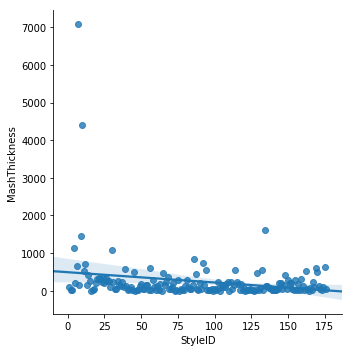

In [18]:
sns.lmplot(x = 'StyleID', y = 'MashThickness', data = beergroup)

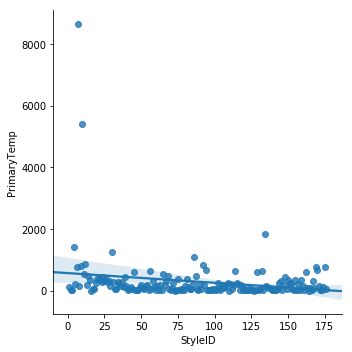

In [19]:
sns.lmplot(x = 'StyleID', y = 'PrimaryTemp', data = beergroup2)

The available values for both of these seem to pretty consistent across styles. These columns could be useful. Let's do a correlation matrix to see if we actually need MashThickness and PrimaryTemp.

In [20]:
beerdum = pd.get_dummies(beer)

In [21]:
beerdum.head()

,StyleID,Size(L),OG,FG,ABV,IBU,Color,BoilSize,BoilTime,BoilGravity,Efficiency,MashThickness,PrimaryTemp,SugarScale_Plato,SugarScale_Specific Gravity,BrewMethod_All Grain,BrewMethod_BIAB,BrewMethod_Partial Mash,BrewMethod_extract
BeerID,,,,,,,,,,,,,,,,,,,
1,45,21.77,1.055,1.013,5.48,17.65,4.83,28.39,75,1.038,70.0,NaN,17.78,0,1,1,0,0,0
2,85,20.82,1.083,1.021,8.16,60.65,15.64,24.61,60,1.070,70.0,NaN,NaN,0,1,1,0,0,0
3,7,18.93,1.063,1.018,5.91,59.25,8.98,22.71,60,NaN,70.0,NaN,NaN,0,1,0,0,0,1
4,7,22.71,1.061,1.017,5.80,54.48,8.50,26.50,60,NaN,70.0,NaN,NaN,0,1,1,0,0,0
5,20,50.00,1.060,1.010,6.48,17.84,4.57,60.00,90,1.050,72.0,NaN,19.00,0,1,1,0,0,0


In [22]:
corrmat = beerdum.corr()
corrmat

,StyleID,Size(L),OG,FG,ABV,IBU,Color,BoilSize,BoilTime,BoilGravity,Efficiency,MashThickness,PrimaryTemp,SugarScale_Plato,SugarScale_Specific Gravity,BrewMethod_All Grain,BrewMethod_BIAB,BrewMethod_Partial Mash,BrewMethod_extract
StyleID,1.000000,-0.006522,0.002699,0.007336,0.006617,-0.141124,0.166669,-0.006301,0.077969,0.002326,0.021515,0.006167,-0.019661,0.003359,-0.003359,0.013983,-0.002336,0.009732,-0.024206
Size(L),-0.006522,1.000000,0.162237,0.141614,-0.013527,-0.029917,-0.018068,0.994143,0.044848,0.176071,0.108826,0.019246,0.004278,0.165177,-0.165177,0.091072,-0.057732,-0.027144,-0.048682
OG,0.002699,0.162237,1.000000,0.936347,0.029432,-0.001655,0.013632,0.165162,0.031825,0.968138,0.067610,0.046841,0.000518,0.966978,-0.966978,0.074990,-0.042509,-0.023688,-0.044976
FG,0.007336,0.141614,0.936347,1.000000,0.026851,-0.000719,0.029848,0.142974,0.028930,0.908611,0.061173,0.040541,0.004477,0.879895,-0.879895,0.069044,-0.039570,-0.021441,-0.041160
ABV,0.006617,-0.013527,0.029432,0.026851,1.000000,0.290889,0.271332,-0.009800,0.120629,0.025421,0.047853,-0.069633,0.060065,-0.011754,0.011754,0.023133,-0.030263,0.009125,-0.005076
IBU,-0.141124,-0.029917,-0.001655,-0.000719,0.290889,1.000000,0.060283,-0.028258,0.078694,-0.007498,-0.033172,-0.044381,0.035510,-0.014984,0.014984,0.002058,-0.005178,-0.004896,0.006195
Color,0.166669,-0.018068,0.013632,0.029848,0.271332,0.060283,1.000000,-0.016798,0.058089,0.013451,-0.017297,-0.038406,0.025622,-0.005038,0.005038,0.007478,-0.010460,0.021961,-0.013485
BoilSize,-0.006301,0.994143,0.165162,0.142974,-0.009800,-0.028258,-0.016798,1.000000,0.051219,0.175972,0.121971,0.017772,0.003000,0.167185,-0.167185,0.103762,-0.054453,-0.036589,-0.064718
BoilTime,0.077969,0.044848,0.031825,0.028930,0.120629,0.078694,0.058089,0.051219,1.000000,0.026921,0.161295,0.006850,-0.079809,0.027187,-0.027187,0.167420,-0.020255,-0.060951,-0.180843
BoilGravity,0.002326,0.176071,0.968138,0.908611,0.025421,-0.007498,0.013451,0.175972,0.026921,1.000000,0.059132,0.050944,0.002268,0.941791,-0.941791,0.067139,-0.047205,-0.015316,-0.033632


Neither MashThickness nor PrimaryTemp correlate very strongly with the StyleID but they don't correlate strongly with any other variable either. I'll keep them for now.

(0, 10)

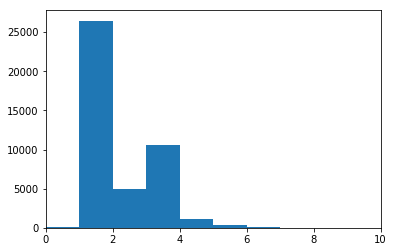

In [23]:
plt.hist(beerdum['MashThickness'].dropna(),bins = 100)
plt.xlim(0,10)

{'boxes': [<matplotlib.lines.Line2D at 0x10f3a6c88>],
 'caps': [<matplotlib.lines.Line2D at 0x10f3ae6d8>,
 'fliers': [<matplotlib.lines.Line2D at 0x10f3b7390>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x10f3aef28>],
 'whiskers': [<matplotlib.lines.Line2D at 0x10f3a6dd8>,
  <matplotlib.lines.Line2D at 0x10f3ae2b0>]}

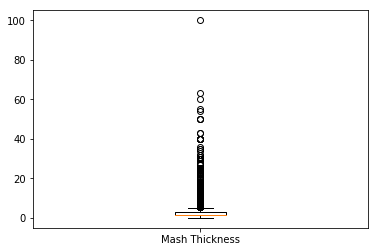

In [24]:
plt.boxplot(beerdum['MashThickness'].dropna(), labels = ['Mash Thickness'])

MashThickness has a lot of really high outliers and the distribution is not normal. It probably makes more sense to replace nan values with the median than the mean.

In [25]:
np.median(beerdum['MashThickness'].dropna())

1.5

The median for MashThickness is 1.5.

(array([4.4000e+01, 2.0000e+00, 3.0000e+00, 1.5000e+01, 3.5000e+01,
        5.0000e+00, 2.3000e+01, 5.0000e+00, 2.1000e+01, 1.0300e+02,
        2.0120e+03, 1.1590e+03, 2.2540e+03, 1.6954e+04, 2.2760e+04,
        4.5200e+03, 8.6600e+02, 1.3300e+02, 1.0000e+02, 6.0000e+00,
        1.6000e+01, 1.9000e+01, 1.0000e+00, 3.0000e+00, 2.0000e+00,
        6.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 5.0000e+00,
        3.0000e+00, 5.5000e+01, 3.3000e+01, 1.8000e+01, 4.0000e+00,
        4.0000e+00, 0.0000e+00, 5.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 2.0000e+00]),
 array([-17.78  , -15.1444, -12.5088,  -9.8732,  -7.2376,  -4.602 ,
         -1.9664,   0.6692,   3.3048,   5.9404,   8.576 ,  11.2116,
         13.8472,  16.4828,  19.1184,  21.754 ,  24.3896,  27.0252,
         29.6608,  32.2964,  34.932 ,  37.5676,  40.2032,  42.8388,
         45.4744,  48.11  ,  50.7456,  53.3812

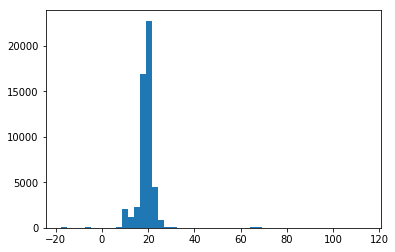

In [26]:
plt.hist(beerdum['PrimaryTemp'].dropna(),bins = 50)


{'boxes': [<matplotlib.lines.Line2D at 0x10e09cb38>],
 'caps': [<matplotlib.lines.Line2D at 0x10e0a6588>,
 'fliers': [<matplotlib.lines.Line2D at 0x10e0ad240>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x10e0a6dd8>],
 'whiskers': [<matplotlib.lines.Line2D at 0x10e09cc88>,
  <matplotlib.lines.Line2D at 0x10e0a6160>]}

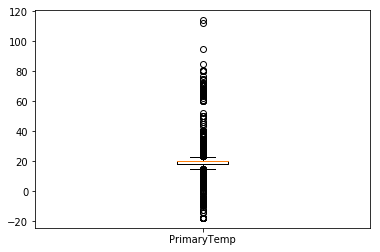

In [27]:
plt.boxplot(beerdum['PrimaryTemp'].dropna(), labels = ['PrimaryTemp'])

In [28]:
np.median(beerdum['PrimaryTemp'].dropna())

20.0

PrimaryTemp also has a lot of very high outliers. I'll replace nan values with the median.

In [29]:
beerdum['PrimaryTemp2'] = beerdum['PrimaryTemp'].fillna(20)

In [30]:
beerdum['MashThickness2'] = beerdum['MashThickness'].fillna(1.5)

In [31]:
beerna = beerdum.drop(columns = ['MashThickness','PrimaryTemp'])

In [32]:
beerna.shape

(73861, 19)

In [53]:
# BoilGravity , OG  and SugarScale_Plato are all very highly correlated with FG.
# BoilSize is too highly correlated with Size(L)
#Negating SugarScale_Specific Gravity will yield a strong positive correlation with FG.
#Mashthickness2 has a low correlation with StyleID and so many nan values. I'll drop it.
beerna2 = pd.DataFrame(beerna.drop(columns = ['SugarScale_Plato','OG','BoilGravity','BoilSize','SugarScale_Specific Gravity','MashThickness2']))

In [54]:
beerna2.shape

(73861, 13)

In [55]:
beerna2.corr()

,StyleID,FG,ABV,IBU,Color,BoilSize,BoilTime,Efficiency,BrewMethod_All Grain,BrewMethod_BIAB,BrewMethod_Partial Mash,BrewMethod_extract,PrimaryTemp2
StyleID,1.000000,0.007336,0.006617,-0.141124,0.166669,-0.006301,0.077969,0.021515,0.013983,-0.002336,0.009732,-0.024206,-0.017755
FG,0.007336,1.000000,0.026851,-0.000719,0.029848,0.142974,0.028930,0.061173,0.069044,-0.039570,-0.021441,-0.041160,0.004840
ABV,0.006617,0.026851,1.000000,0.290889,0.271332,-0.009800,0.120629,0.047853,0.023133,-0.030263,0.009125,-0.005076,0.046318
IBU,-0.141124,-0.000719,0.290889,1.000000,0.060283,-0.028258,0.078694,-0.033172,0.002058,-0.005178,-0.004896,0.006195,0.022619
Color,0.166669,0.029848,0.271332,0.060283,1.000000,-0.016798,0.058089,-0.017297,0.007478,-0.010460,0.021961,-0.013485,0.023264
BoilSize,-0.006301,0.142974,-0.009800,-0.028258,-0.016798,1.000000,0.051219,0.121971,0.103762,-0.054453,-0.036589,-0.064718,0.005285
BoilTime,0.077969,0.028930,0.120629,0.078694,0.058089,0.051219,1.000000,0.161295,0.167420,-0.020255,-0.060951,-0.180843,-0.075244
Efficiency,0.021515,0.061173,0.047853,-0.033172,-0.017297,0.121971,0.161295,1.000000,0.456775,0.093831,-0.101126,-0.707998,-0.059838
BrewMethod_All Grain,0.013983,0.069044,0.023133,0.002058,0.007478,0.103762,0.167420,0.456775,1.000000,-0.632036,-0.321095,-0.521409,-0.023043
BrewMethod_BIAB,-0.002336,-0.039570,-0.030263,-0.005178,-0.010460,-0.054453,-0.020255,0.093831,-0.632036,1.000000,-0.098707,-0.160285,-0.024463


In [56]:
beerna2 = pd.DataFrame(beerna2.dropna())

In [57]:
beerna2['StyleID'].nunique()

176

In [ ]:
beerna2.shape

In [58]:
exes = beerna2.drop(columns = ['StyleID'])
columns = exes.columns
scaler = MinMaxScaler()
scaled_df = scaler.fit_transform(exes)
scaled_df = pd.DataFrame(scaled_df, columns = columns)
scaled_df.columns


Index(['FG', 'ABV', 'IBU', 'Color', 'BoilSize', 'BoilTime', 'Efficiency',
       'BrewMethod_All Grain', 'BrewMethod_BIAB', 'BrewMethod_Partial Mash',
       'BrewMethod_extract', 'PrimaryTemp2'],
      dtype='object')

In [59]:
y = np.ravel(beerna2['StyleID'])
y = y.astype(str)
X = scaled_df
# Declare a logistic regression classifier.
# Parameter regularization coefficient C described above.
lr = LogisticRegression(C = 1e6)


In [60]:

##Fit the model.
fit = lr.fit(X, y)
# Display.
print('Coefficients')
print(fit.coef_)
print(fit.intercept_)
pred_y_sklearn = lr.predict(X)
print('\n Percentage accuracy')
print(lr.score(X, y))

Coefficients
[[ 1.79359528e+00 -3.03690398e+01  2.81189563e+00 ... -1.95696092e+00
  -1.47911169e-02 -1.03141176e+01]
 [ 2.09663229e+00 -9.23263848e+00 -1.00271468e+01 ...  1.81816663e-01
  -1.89287884e+00  3.51607830e+00]
 [ 5.67868689e+00  5.68789564e+00 -6.73683303e+01 ... -1.82560503e+00
  -6.01662218e-01  8.58835908e-01]
 ...
 [-4.18775469e+01  3.20548053e+00 -3.71587419e+01 ... -9.02257580e-01
  -1.15877500e+00  2.86690526e+00]
 [-3.85442769e-01 -2.98594720e+00 -1.52574723e+02 ... -2.82793204e-01
  -9.53453549e-01  5.23733564e+00]
 [-5.14596151e+01  5.24860265e+00 -1.93040491e+00 ... -9.75169110e+00
   1.03066934e+00  7.12528531e-01]]
[ -2.27713556  -3.10952789  -6.9555113   -2.13240344  -7.76555396
  -2.99776374  -1.53150651   1.2189792   -0.65189933  -0.28854228
  -5.16683085  -5.02602848  -5.97231797  -1.1824734   -2.45023563
  -1.22704556  -4.36920231  -3.40758828  -2.98208061  -4.43180741
  -7.53494785  -5.72985605  -7.14919157  -4.46132575  -6.09274396
  -6.21102998   0.085

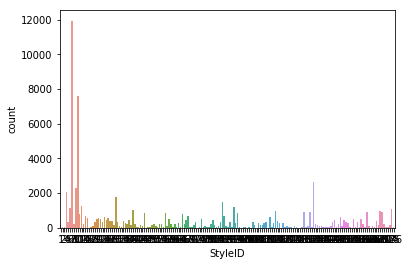

In [41]:
sns.countplot(beerna['StyleID'])


In [42]:
freq = pd.DataFrame(beerna['StyleID'].value_counts().reset_index())
freqcut = pd.DataFrame(freq[freq['StyleID'] > 1500])
freqcut

,index,StyleID
0,7,11940
1,10,7581
2,134,2617
3,9,2277
4,4,2038
5,30,1753


In [43]:
beernacut = pd.DataFrame(beerna.loc[beerna['StyleID'].isin(freqcut['index'])])
beernacut.head()

,StyleID,Size(L),OG,FG,ABV,IBU,Color,BoilSize,BoilTime,BoilGravity,Efficiency,SugarScale_Plato,SugarScale_Specific Gravity,BrewMethod_All Grain,BrewMethod_BIAB,BrewMethod_Partial Mash,BrewMethod_extract,PrimaryTemp2,MashThickness2
BeerID,,,,,,,,,,,,,,,,,,,
3,7,18.93,1.063,1.018,5.91,59.25,8.98,22.71,60,NaN,70.0,0,1,0,0,0,1,20.0,1.5
4,7,22.71,1.061,1.017,5.80,54.48,8.50,26.50,60,NaN,70.0,0,1,1,0,0,0,20.0,1.5
6,10,24.61,1.055,1.013,5.58,40.12,8.00,29.34,70,1.047,79.0,0,1,1,0,0,0,20.0,1.5
11,7,25.00,1.064,1.014,6.63,64.26,7.78,29.00,90,1.055,74.0,0,1,1,0,0,0,18.0,1.5
12,7,15.14,1.066,1.015,6.62,111.00,14.26,11.36,90,NaN,70.0,0,1,0,1,0,0,20.0,1.5


In [44]:
beernacut.corr()

,StyleID,Size(L),OG,FG,ABV,IBU,Color,BoilSize,BoilTime,BoilGravity,Efficiency,SugarScale_Plato,SugarScale_Specific Gravity,BrewMethod_All Grain,BrewMethod_BIAB,BrewMethod_Partial Mash,BrewMethod_extract,PrimaryTemp2,MashThickness2
StyleID,1.000000,-0.000148,-0.013028,-0.021834,-0.000963,-0.199365,-0.126548,0.001812,0.105497,-0.013774,0.038663,-0.010769,0.010769,0.021841,0.013988,-0.003704,-0.044869,0.197357,-0.007572
Size(L),-0.000148,1.000000,0.190714,0.182026,-0.013944,-0.043874,-0.014620,0.996224,0.056097,0.211376,0.115496,0.192382,-0.192382,0.097155,-0.061302,-0.027525,-0.052596,0.000776,0.041840
OG,-0.013028,0.190714,1.000000,0.958202,0.020163,-0.009669,-0.005979,0.191030,0.033508,0.977018,0.064647,0.982867,-0.982867,0.073929,-0.044340,-0.023658,-0.040932,-0.002209,0.067364
FG,-0.021834,0.182026,0.958202,1.000000,0.020018,-0.007124,-0.001875,0.181942,0.032043,0.936716,0.061442,0.926046,-0.926046,0.069848,-0.042541,-0.020227,-0.039274,-0.001978,0.060362
ABV,-0.000963,-0.013944,0.020163,0.020018,1.000000,0.250366,0.204867,-0.011552,0.078984,0.016305,0.091035,-0.008213,0.008213,0.031330,-0.016415,0.000969,-0.026950,0.018403,-0.044972
IBU,-0.199365,-0.043874,-0.009669,-0.007124,0.250366,1.000000,0.061352,-0.043378,0.059745,-0.014787,-0.040530,-0.018223,0.018223,-0.013215,-0.001587,0.000515,0.020436,-0.016991,-0.038493
Color,-0.126548,-0.014620,-0.005979,-0.001875,0.204867,0.061352,1.000000,-0.014815,0.018727,-0.007251,-0.051859,-0.013397,0.013397,0.001306,-0.031612,0.032189,0.013737,0.007820,-0.009784
BoilSize,0.001812,0.996224,0.191030,0.181942,-0.011552,-0.043378,-0.014815,1.000000,0.062263,0.209486,0.129635,0.192548,-0.192548,0.110544,-0.058707,-0.036676,-0.068999,0.000220,0.043442
BoilTime,0.105497,0.056097,0.033508,0.032043,0.078984,0.059745,0.018727,0.062263,1.000000,0.033322,0.164201,0.032162,-0.032162,0.158595,-0.017516,-0.056848,-0.171964,0.010425,0.045620
BoilGravity,-0.013774,0.211376,0.977018,0.936716,0.016305,-0.014787,-0.007251,0.209486,0.033322,1.000000,0.059497,0.964897,-0.964897,0.067810,-0.049104,-0.018947,-0.029709,-0.001000,0.065835


In [45]:
beernacut.shape

(28206, 19)

In [46]:
# BoilGravity , OG  and SugarScale_Plato are all very highly correlated with FG. 
#Size(L) is highly correlated with BoilSize
#SugarScale_Specific Gravity, if negated, would correlated highly with FG.
#MashThickness2 has a low correlation with StyleID and so many nan values. I'll drop it.
beernacut = pd.DataFrame(beernacut.drop(columns = ['SugarScale_Plato','OG','BoilGravity','Size(L)','SugarScale_Specific Gravity','MashThickness2']))

In [47]:
beernacut.shape

(28206, 13)

In [48]:
beernacut = pd.DataFrame(beernacut.dropna())

In [49]:
beernacut['StyleID'].nunique()

6

In [50]:
exes = beernacut.drop(columns = ['StyleID'])
columns = exes.columns
scaler = MinMaxScaler()
scaled_df = scaler.fit_transform(exes)
scaled_df = pd.DataFrame(scaled_df, columns = columns)
scaled_df.columns



Index(['FG', 'ABV', 'IBU', 'Color', 'BoilSize', 'BoilTime', 'Efficiency',
       'BrewMethod_All Grain', 'BrewMethod_BIAB', 'BrewMethod_Partial Mash',
       'BrewMethod_extract', 'PrimaryTemp2'],
      dtype='object')

In [51]:
# Declare a logistic regression classifier.
# Parameter regularization coefficient C described above.
lr = LogisticRegression(C = 1e6)
y = np.ravel(beernacut['StyleID'])
y.astype(str)
X = scaled_df
##Fit the model.
fit = lr.fit(X, y)
# Display.
print('Coefficients')
print(fit.coef_)
print(fit.intercept_)
pred_y_sklearn = lr.predict(X)
print('\n Percentage accuracy')
print(lr.score(X, y))


Coefficients
[[ -0.26773546 -15.68947486 -34.83710269   6.22157561  -2.57593785
    0.27830964   0.62419447  -0.26715834  -0.37770579  -0.17835126
    0.23621541  -2.91931623]
 [  0.5284457   30.07392847  95.03960251  -1.63181964   0.91162663
   -0.86814057  -0.71013501  -0.58671144  -0.64254881  -0.67373429
   -0.84277096  -4.02632357]
 [  0.79502033  -3.13849913 -75.23175677   2.88653232   2.97221826
   -3.48498097  -1.18645732   0.64047265   0.55293046   0.3082401
    0.45091192  -5.96571932]
 [  0.2695109  -24.7941468   -9.8561977   -1.94180252  -2.15097802
   -1.46091845   1.45885452   0.38406474   0.50150422   0.58935448
    0.72373215  -3.00260915]
 [ -0.61662119 -18.85324139 -75.36842262 -13.15708987  -0.8558358
    0.79193728   0.5630561    0.6675896    0.54692253   0.76490896
    0.64442946  -4.51498359]
 [ -2.28165288  17.35981061 -92.67291043  -5.50448009  -2.51613807
    7.26565111  -0.81128334  -2.3094      -2.21290262  -2.44598152
   -2.95447404  25.25370976]]
[-0.586999

In [52]:
#print('\n Predicted Crossed with Outcome by Style ID')
#print(pd.crosstab(pred_y_sklearn, y))

In [69]:
freq = pd.DataFrame(beerna2['StyleID'].value_counts().reset_index())
freqcut = pd.DataFrame(freq[freq['StyleID'] > 5])
freqcut['index'].unique()

array([  7,  10, 134,   9,   4,  30,  86,  12,  92,   6, 175,  39, 169,
       114, 132, 162, 170, 129,  94,  56,  45,  11,  65,  87,  68,  14,
       148,  24, 111,  15,  26,  21,  22, 155,  75,  20,  58, 159,  81,
       150,  37,  67, 145,  25, 167,  27,  28,  34, 115,  72, 144,  23,
        19,  31,   5, 109, 102,  85, 157, 151,  90, 116, 152, 113, 105,
        35, 118,  93, 108,  63,  53,  50,  54, 160,  13,  66, 147,   8,
       135,  40, 171,  61,  80,  59,  36,  29, 136,  49, 106, 174,  38,
        82,  71, 168, 107,  43, 103,   1, 120, 165, 137,  51, 124, 138,
       143, 163, 131,  32, 149,  44,  88,  57,  18,  77,  84,  98, 100,
       153, 176, 112,  42,  91, 119,  83,  33,  69,  52, 158,  70, 146,
        17, 156, 142, 128,  55,  60, 140,  41, 172, 173, 139,   2, 161,
        74, 121,  89,  48,  78, 130,  64,  47, 166, 122,  97, 125, 141,
       133,  76,   3,  62,  79,  95,  96, 117,  46, 123, 104, 126, 154,
       101, 110,  99,  16])

In [75]:
freqcut['index'].nunique()

173

In [77]:
beerna2cut = pd.DataFrame(beerna2.loc[beerna2['StyleID'].isin(freqcut['index'].unique())])
beerna2cut['StyleID'].nunique()

173

In [78]:
from sklearn import ensemble
from sklearn.model_selection import cross_val_score


In [84]:
rfc = ensemble.RandomForestClassifier(n_jobs = -1)
y = np.ravel(beerna2cut['StyleID'])
X = pd.DataFrame(beerna2cut.drop(columns = ['StyleID']))


In [85]:
cross_val_score(rfc,X,y,cv=5)

array([0.31743465, 0.32268522, 0.3227008 , 0.32278868, 0.31800871])

In [86]:
rfc.fit(X,y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

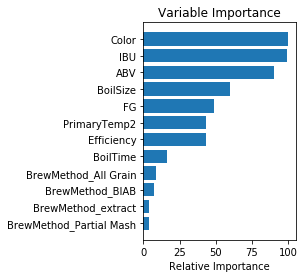

In [87]:

feature_importance = rfc.feature_importances_

# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

In [88]:
# Create training and test sets.
offset = int(X.shape[0] * 0.9)

# Put 90% of the data in the training set.
X_train, y_train = X[:offset], y[:offset]

# And put 10% in the test set.
X_test, y_test = X[offset:], y[offset:]

In [ ]:
# We'll make 500 iterations, use 2-deep trees, and set our loss function.
params = {'n_estimators': 500,
          'max_depth': 2,
          'loss': 'deviance'}

# Initialize and fit the model.
clf = ensemble.GradientBoostingClassifier(**params,subsample=.8)
clf.fit(X_train, y_train)

predict_train = clf.predict(X_train)
predict_test = clf.predict(X_test)



In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(y_train, predict_train, normalize=True, sample_weight=None)

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, predict_test, normalize=True, sample_weight=None)